In [1]:
import os

In [2]:
from pathlib import Path

In [3]:
import glob

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
from skimage.io import imread,imshow,imsave

In [27]:
from keras.preprocessing.image import load_img,array_to_img,img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input,ZeroPadding2D,Cropping2D,BatchNormalization
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split

In [28]:
np.random.seed(111)

In [29]:
from subprocess import check_output

In [30]:
#Providing path for dataset
input_dir = Path('D:/')
train = input_dir/'train'
train_cleaned = input_dir/'train_cleaned'
test = input_dir/'test'

In [31]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))


Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


In [32]:
samples = train_images[:3] +train_labels[:3]


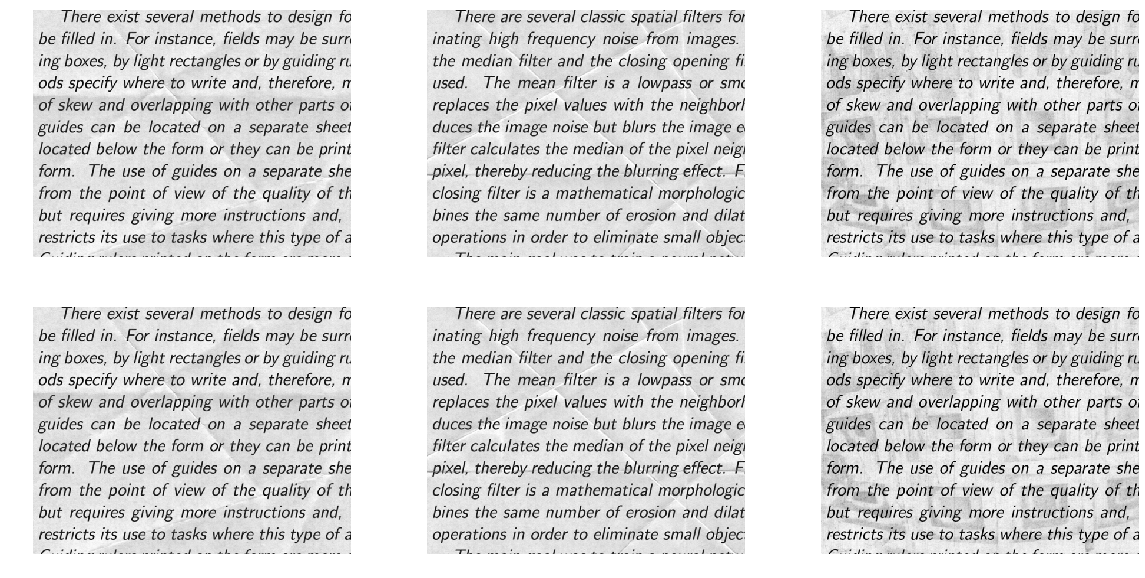

In [33]:
f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show() 

In [34]:
#Autoencoder Function
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    #x = ZeroPadding2D(padding=((12,0),(4,0)))(input_img)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x=BatchNormalization()(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    #x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv3')(x)
    #x = MaxPooling2D((2,2), padding='same', name='pool3')(x)
    #x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    #x = MaxPooling2D((2,2), padding='same', name='pool4')(x)
    
    
    #decoder
    #x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv5')(x)
    #x = UpSampling2D((2,2), name='upsample1')(x)
    #x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv6')(x)
    #x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv7')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)
    x=BatchNormalization()(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv8')(x)
    x = UpSampling2D((2,2), name='upsample4')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv9')(x)
    #x= Cropping2D(cropping=((12,0),(4,0)))(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [35]:
autoencoder = build_autoenocder()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 128)     1280      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 210, 270, 128)     512       
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 256)     295168    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 256)     0         
_________________________________________________________________
Conv7 (Conv2D)               (None, 105, 135, 256)     590080    
__________

In [36]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255. #normalising
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [38]:
import tensorflow as tf

#Callback function
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('loss')<0.001):
            print("\nReached 90% accuracy so cancelling training")
            self.model.stop_training=True

In [39]:
callbacks=myCallBack()

In [42]:
# Train your model
autoencoder.fit(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_valid, y_valid),callbacks=[callbacks])

Train on 129 samples, validate on 15 samples
Epoch 1/100
129/129 [==============================] - 23s 182ms/step - loss: 0.1721 - val_loss: 0.1381
Epoch 2/100
129/129 [==============================] - 21s 162ms/step - loss: 0.1173 - val_loss: 0.1295
Epoch 3/100
129/129 [==============================] - 21s 163ms/step - loss: 0.1077 - val_loss: 0.1198
Epoch 4/100
129/129 [==============================] - 21s 163ms/step - loss: 0.1026 - val_loss: 0.1118
Epoch 5/100
129/129 [==============================] - 21s 163ms/step - loss: 0.1001 - val_loss: 0.1090
Epoch 6/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0981 - val_loss: 0.1096
Epoch 7/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0972 - val_loss: 0.1053
Epoch 8/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0962 - val_loss: 0.1040
Epoch 9/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0956 - val_loss: 0.1029
Epoch 10/100
129/12

129/129 [==============================] - 21s 163ms/step - loss: 0.0886 - val_loss: 0.0959
Epoch 79/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0885 - val_loss: 0.0958
Epoch 80/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0957 - val_loss: 1.7909
Epoch 81/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0937 - val_loss: 0.1535
Epoch 82/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0903 - val_loss: 0.1095
Epoch 83/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0897 - val_loss: 0.1012
Epoch 84/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0894 - val_loss: 0.0972
Epoch 85/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0890 - val_loss: 0.0966
Epoch 86/100
129/129 [==============================] - 21s 163ms/step - loss: 0.0889 - val_loss: 0.0968
Epoch 87/100
129/129 [==============================] - 21s 163ms/st

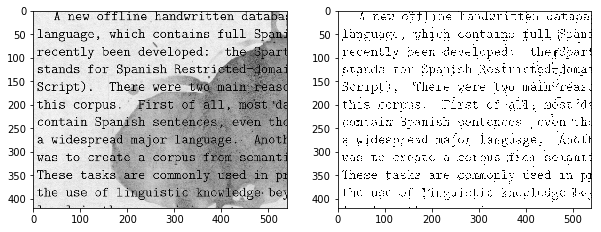

In [45]:
sample_test = load_img(test/ test_images[14], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()